# Execution

This notebook explains how PartiQL executes, with some discussion of its implementation.

## Data model

As discussed in [02-data-model.ipynb](02-data-model.ipynb), the only allowed types are PLURP (PLUR in this demo). In a rowwise, dynamically typed interpreter, this means there are only values, records, and lists. Since PartiQL is list order-independent and merges items with the same key, the lists are really sets, though the word "list" appears in the implementation and error messages.

Every value entering or exiting the PartiQL interpreter is a `data.Instance`, even simple numbers.

In [1]:
import data

arrays = data.RecordArray({
    "x": data.PrimitiveArray([0.1, 0.2, 0.3]),
    "y": data.PrimitiveArray([1000, 2000, 3000]),
    "table1": data.ListArray([0, 3, 3], [3, 3, 5], data.RecordArray({
            "a": data.PrimitiveArray([1.1, 2.2, 3.3, 4.4, 5.5]),
            "b": data.PrimitiveArray([100, 200, 300, 400, 500])
        })
    ),
    "table2": data.ListArray([0, 2, 3], [2, 3, 8], data.RecordArray({
            "b": data.PrimitiveArray([True, False, True, False, False, True, True, True]),
            "c": data.PrimitiveArray([10, 20, 100, 1, 2, 3, 4, 5])
        })
    ),
    "stuff": data.ListArray([0, 3, 3], [3, 3, 5], data.PrimitiveArray([1, 2, 3, 4, 5]))
})

arrays.tolist()

[{'x': 0.1,
  'y': 1000,
  'table1': [{'a': 1.1, 'b': 100}, {'a': 2.2, 'b': 200}, {'a': 3.3, 'b': 300}],
  'table2': [{'b': True, 'c': 10}, {'b': False, 'c': 20}],
  'stuff': [1, 2, 3]},
 {'x': 0.2,
  'y': 2000,
  'table1': [],
  'table2': [{'b': True, 'c': 100}],
  'stuff': []},
 {'x': 0.3,
  'y': 3000,
  'table1': [{'a': 4.4, 'b': 400}, {'a': 5.5, 'b': 500}],
  'table2': [{'b': False, 'c': 1},
   {'b': False, 'c': 2},
   {'b': True, 'c': 3},
   {'b': True, 'c': 4},
   {'b': True, 'c': 5}],
  'stuff': [4, 5]}]

In [2]:
arrays.setindex()

instances = data.instantiate(arrays)
instances

List{ 
    Rec#0(0){ 
        x = Value#0(0){ 0.1 }
        y = Value#0(0){ 1000 }
        table1 = List#0(0){ 
            Rec#1(0 0){ 
                a = Value#1(0 0){ 1.1 }
                b = Value#1(0 0){ 100 }
            }
            Rec#1(0 1){ 
                a = Value#1(0 1){ 2.2 }
                b = Value#1(0 1){ 200 }
            }
            Rec#1(0 2){ 
                a = Value#1(0 2){ 3.3 }
                b = Value#1(0 2){ 300 }
            }
        }
        table2 = List#0(0){ 
            Rec#2(0 0){ 
                b = Value#2(0 0){ True }
                c = Value#2(0 0){ 10 }
            }
            Rec#2(0 1){ 
                b = Value#2(0 1){ False }
                c = Value#2(0 1){ 20 }
            }
        }
        stuff = List#0(0){ 
            Value#3(0 0){ 1 }
            Value#3(0 1){ 2 }
            Value#3(0 2){ 3 }
        }
    }
    Rec#0(1){ 
        x = Value#0(1){ 0.2 }
        y = Value#0(1){ 2000 }
        table1 = List#0(1){ 
    

## Inputs and outputs

Next, we'll run a few simple examples to show what the runtime engine requires and produces.

If you have not already done so, install the [Lark parser](https://github.com/lark-parser/lark#readme) and Matplotlib.

In [6]:
!pip install lark-parser matplotlib

In [3]:
import interpreter

The interpreter takes a source string and a `data.ListInstance` of `data.RecordInstances` as input.

It returns any newly assigned variables (as a `data.ListInstance` of `data.RecordInstances`) and the hierarchy of counters, which may be a single counter (total number of events) or a directory of histograms.

In [4]:
output, counter = interpreter.run(r"""

z = x + 1

hist z by regular(100, 1, 1.5) named "h"

""", instances)

In [5]:
output

List{ 
    Rec#0(0){ 
        z = Value#0(0){ 1.1 }
    }
    Rec#0(1){ 
        z = Value#0(1){ 1.2 }
    }
    Rec#0(2){ 
        z = Value#0(2){ 1.3 }
    }
}

In [6]:
counter.allkeys()

['h']

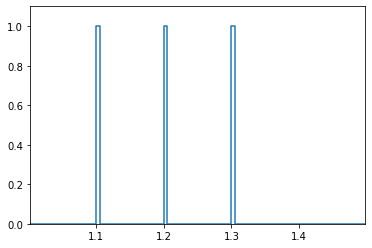

In [7]:
counter["h"].mpl()

Variables assigned in nested blocks will *not* be returned, but histograms defined in these blocks will.

In [8]:
output, counter = interpreter.run(r"""

table1 with {
    z = a + 1
    hist z by regular(100, 0, 10) named "h"
}

""", instances)

In [9]:
output

List{ 
}

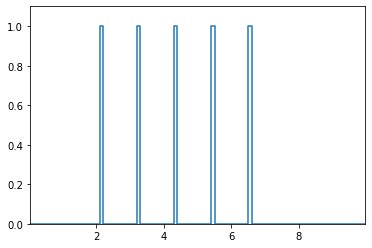

In [10]:
counter["h"].mpl()

To get nested quantities as output, be sure to assign them to a top-level variable.

In [11]:
output, counter = interpreter.run(r"""

top = table1 with {
    z = a + 1
    hist z by regular(100, 0, 10) named "h"
}

""", instances)

In [12]:
output

List{ 
    Rec#0(0){ 
        top = List#0(0){ 
            Rec#1(0 0){ 
                a = Value#1(0 0){ 1.1 }
                b = Value#1(0 0){ 100 }
                z = Value#1(0 0){ 2.1 }
            }
            Rec#1(0 1){ 
                a = Value#1(0 1){ 2.2 }
                b = Value#1(0 1){ 200 }
                z = Value#1(0 1){ 3.2 }
            }
            Rec#1(0 2){ 
                a = Value#1(0 2){ 3.3 }
                b = Value#1(0 2){ 300 }
                z = Value#1(0 2){ 4.3 }
            }
        }
    }
    Rec#0(1){ 
        top = List#0(1){ 
        }
    }
    Rec#0(2){ 
        top = List#0(2){ 
            Rec#1(2 0){ 
                a = Value#1(2 0){ 4.4 }
                b = Value#1(2 0){ 400 }
                z = Value#1(2 0){ 5.4 }
            }
            Rec#1(2 1){ 
                a = Value#1(2 1){ 5.5 }
                b = Value#1(2 1){ 500 }
                z = Value#1(2 1){ 6.5 }
            }
        }
    }
}

Variables assigned at the top-level of the source are a functional return value, but histograms and counters are a side-effect.

Histograms nested in a `cut` or `vary` are nested in their counters.

In [13]:
output, counter = interpreter.run(r"""
cut x > 0.1 named "c" {
    table2 with {
        hist c by regular(100, 0, 10) named "h"
    }
}
""", instances)

In [14]:
counter.allkeys()

['c', 'c/h']

In [15]:
counter["c"]

<DirectoryCounter 2 (2.0 +- 1.4142135623730951)>

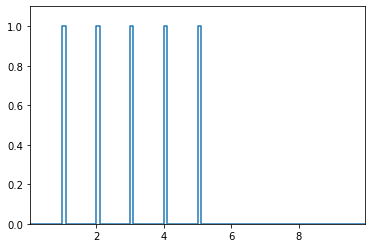

In [16]:
counter["c/h"].mpl()

## Scalar expressions

Trivial assignment is one way to pass on values from intput to output.

In [17]:
output, counter = interpreter.run(r"""

x = x

""", instances); output

List{ 
    Rec#0(0){ 
        x = Value#0(0){ 0.1 }
    }
    Rec#0(1){ 
        x = Value#0(1){ 0.2 }
    }
    Rec#0(2){ 
        x = Value#0(2){ 0.3 }
    }
}

Missing values are handled as unions of records with a field with records without that field. They're only passed through an expression if safe navigation operators (`?`) are used (or explicit checks for `has`).

In [18]:
output, counter = interpreter.run(r"""

a = if x > 0.1 then 100

b = if x > 0.1 then 100 else 200

c = ?a

d = if has a then 100 else 200

""", instances); output

List{ 
    Rec#0(0){ 
        b = Value{ 200 }
        d = Value{ 200 }
    }
    Rec#0(1){ 
        a = Value{ 100 }
        b = Value{ 100 }
        c = Value{ 100 }
        d = Value{ 100 }
    }
    Rec#0(2){ 
        a = Value{ 100 }
        b = Value{ 100 }
        c = Value{ 100 }
        d = Value{ 100 }
    }
}

Temporary variables don't appear if they're in a curly-brackets scope.

In [19]:
output, counter = interpreter.run(r"""

a = {
    tmp1 = x + 1
    tmp2 = x * 100
    tmp2**2
}

""", instances); output

List{ 
    Rec#0(0){ 
        a = Value#0(0){ 100.0 }
    }
    Rec#0(1){ 
        a = Value#0(1){ 400.0 }
    }
    Rec#0(2){ 
        a = Value#0(2){ 900.0 }
    }
}

## Set operations

The `as` operator turns any set into a set of records nested within a single field.

In the example below, `out1` does not have a record structure, but `out2` does—the same data is packed in a field named `nested`.

In [20]:
output, counter = interpreter.run(r"""

out1 = stuff
out2 = stuff as nested

""", instances); output

List{ 
    Rec#0(0){ 
        out1 = List#0(0){ 
            Value#3(0 0){ 1 }
            Value#3(0 1){ 2 }
            Value#3(0 2){ 3 }
        }
        out2 = List#0(0){ 
            Rec#3(0 0){ 
                nested = Value#3(0 0){ 1 }
            }
            Rec#3(0 1){ 
                nested = Value#3(0 1){ 2 }
            }
            Rec#3(0 2){ 
                nested = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        out1 = List#0(1){ 
        }
        out2 = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out1 = List#0(2){ 
            Value#3(2 0){ 4 }
            Value#3(2 1){ 5 }
        }
        out2 = List#0(2){ 
            Rec#3(2 0){ 
                nested = Value#3(2 0){ 4 }
            }
            Rec#3(2 1){ 
                nested = Value#3(2 1){ 5 }
            }
        }
    }
}

It is also a special case of sampling without replacement.

Below, we see that each record has an `x` and a `y` field, and these are unique pairs of the original data, per-event: `(1, 2)`, `(1, 3)`, `(2, 3)` in the first event and only `(4, 5)` in the third event. (The second event is empty.)

In [21]:
output, counter = interpreter.run(r"""

out = stuff as (x, y)

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#3*#3(0 0){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 1){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 2){ 3 }
            }
            Rec#3*#3(0 2){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#3*#3(2 0){ 
                x = Value#3(2 0){ 4 }
                y = Value#3(2 1){ 5 }
            }
        }
    }
}

The natural alternative to sampling without replacement is sampling with replacement, which can be built from `as` and `cross` (cross-join).

The cross-join computes a Cartesian product, just as it does in SQL. Promoting each set of integers into sets of records makes them mergable (`x` and `y` go into the same output records).

Now the pairs are `(1, 1)`, `(1, 2)`, `(1, 3)`, `(2, 1)`, `(2, 2)`, `(2, 3)`, `(3, 1)`, `(3, 2)`, `(3, 3)` in the first event and `(4, 4)`, `(4, 5)`, `(5, 4)`, `(5, 5)` in the third event. (The second event is empty.)

In [22]:
output, counter = interpreter.run(r"""

out = stuff as x cross stuff as y

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#3*#3(0 0){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 1){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 2){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 2){ 3 }
            }
            Rec#3*#3(0 3){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 4){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 5){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 2){ 3 }
            }
            Rec#3*#3(0 6){ 
                x = Value#3(0 2){ 3 }
                y = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 7){ 
                x = Value#3(0 2){ 3 }
                y = Value#3(0 1){ 2 }
            }
        

For added flair, we can `group by` either `x` or `y` to build sets of sets. The Cartesian grid pattern should be more clear.

In [23]:
output, counter = interpreter.run(r"""

out = stuff as x cross stuff as y group by x

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            List#4(0 0){ 
                Rec#3*#3(0 0){ 
                    x = Value#3(0 0){ 1 }
                    y = Value#3(0 0){ 1 }
                }
                Rec#3*#3(0 1){ 
                    x = Value#3(0 0){ 1 }
                    y = Value#3(0 1){ 2 }
                }
                Rec#3*#3(0 2){ 
                    x = Value#3(0 0){ 1 }
                    y = Value#3(0 2){ 3 }
                }
            }
            List#4(0 1){ 
                Rec#3*#3(0 3){ 
                    x = Value#3(0 1){ 2 }
                    y = Value#3(0 0){ 1 }
                }
                Rec#3*#3(0 4){ 
                    x = Value#3(0 1){ 2 }
                    y = Value#3(0 1){ 2 }
                }
                Rec#3*#3(0 5){ 
                    x = Value#3(0 1){ 2 }
                    y = Value#3(0 2){ 3 }
                }
            }
            List#4(0 2){ 
                Rec#3*#3(0 6){ 
          

The cross-join/Cartesian product is one kind of a join: two sets of records are combined to make one set of records. The output records have fields from both input record types and the set is derived from a combinatorial rule, in this case: "for all in the left set, merge with each of the right set."

If we didn't give the records in the left and right sets distinct field names with `as`, then they could overshadow each other. That is, if the left and right both had a field named `x`, only the left's `x` would show up in the results (by convention, left wins over right). Perhaps it would be better if a situation like this raises an error...

The output records don't necessarily have distinct values for all fields. The entities, defined by hidden surrogate keys, are guaranteed distinct, but the field values might not be.

In [24]:
output, counter = interpreter.run(r"""

out = stuff as x cross stuff as x

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#3*#3(0 0){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 1){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 2){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3*#3(0 3){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 4){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 5){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3*#3(0 6){ 
                x = Value#3(0 2){ 3 }
            }
            Rec#3*#3(0 7){ 
                x = Value#3(0 2){ 3 }
            }
            Rec#3*#3(0 8){ 
                x = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#3*#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
            Rec#3*#3(2 1){ 
          

In the above, it looks like these sets contain multiple values of `{"x": 4}` and `{"x": 5}`, but their index keys are different. (They are different ordered tuples of elements from the left and right sets.)

In [25]:
[[y.row for y in x["out"]] for x in output]

[[RowKey((0, 0), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 1), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 2), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 3), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 4), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 5), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 6), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 7), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((0, 8), CrossRef(<Ref 3>, <Ref 3>))],
 [],
 [RowKey((2, 0), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((2, 1), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((2, 2), CrossRef(<Ref 3>, <Ref 3>)),
  RowKey((2, 3), CrossRef(<Ref 3>, <Ref 3>))]]

Cross-join is, in a sense, the simplest join because it creates a new index: `CrossRef(<Ref X>, <Ref Y>)` is distinct from `<Ref X>` and `<Ref Y>`, and the only way to get another one is to `cross` sets with indexes `<Ref X>` and `<Ref Y>` again.

The next-simplest is `join`, which requires the left and right sets to have the same index and returns a set with the same index. In SQL terms, PartiQL's `join` is an `INNER JOIN`, taking an element from the left and right sets only if they have the same index key. Again in SQL terms, this `INNER JOIN` is implicitly `ON` the hidden surrogate index, not any other columns. With that restriction, `join` effectively becomes set intersection.

I had considered calling it `intersect`, rather than `join` because it is set intersection, but the way fields from records in the left and right sets are mixed is more reminiscent of an SQL join.

In [26]:
output, counter = interpreter.run(r"""

out = stuff as x join stuff as y

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#3(0 0){ 
                x = Value#3(0 0){ 1 }
                y = Value#3(0 0){ 1 }
            }
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 1){ 2 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
                y = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
                y = Value#3(2 0){ 4 }
            }
            Rec#3(2 1){ 
                x = Value#3(2 1){ 5 }
                y = Value#3(2 1){ 5 }
            }
        }
    }
}

To show what this is doing, let's filter the left and right sets with `where`. Even and odd values have no overlap.

In [27]:
output, counter = interpreter.run(r"""

evens = stuff as x where x % 2 == 0
odds  = stuff as x where x % 2 == 1

out = evens join odds

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        odds = List#0(0){ 
            Rec#3(0 0){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
            }
        }
        out = List#0(0){ 
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        odds = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        odds = List#0(2){ 
            Rec#3(2 1){ 
                x = Value#3(2 1){ 5 }
            }
        }
        out = List#0(2){ 
        }
    }
}

But the overlap of evens and `2 <= x and x <= 4` is `2` and `4`.

In [28]:
output, counter = interpreter.run(r"""

evens  = stuff as x where x % 2 == 0
middle = stuff as x where 2 <= x and x <= 4

out = evens join middle

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        middle = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
            }
        }
        out = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        middle = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        middle = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        out = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
    }
}

To see how this is like an SQL `INNER JOIN`, consider records with different fields: the left records have an `x` and the right records have a `y`. When they have an overlapping index, the merged records have `x` and `y`.

In [29]:
output, counter = interpreter.run(r"""

evens  = stuff as x where x % 2 == 0
middle = stuff as y where 2 <= y and y <= 4

out = evens join middle

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        middle = List#0(0){ 
            Rec#3(0 1){ 
                y = Value#3(0 1){ 2 }
            }
            Rec#3(0 2){ 
                y = Value#3(0 2){ 3 }
            }
        }
        out = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
                y = Value#3(0 1){ 2 }
            }
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        middle = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        middle = List#0(2){ 
            Rec#3(2 0){ 
                y = Value#3(2 0){ 4 }
            }
        }
        out = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
                y = Value#3(2 0){ 4 }
      

The opposite of PartiQL's `join` (like SQL's `INNER JOIN` on the hidden surrogate key) is PartiQL's `union` (like SQL's `FULL OUTER JOIN` on the hidden surrogate key).

Just as `join` acts as set intersection, `union` acts as set union. I chose to use the word "`union`" in this case because field names of the records in the left and right sets are often different, so this behaves intuitively as a user would expect set union to behave.

Here is an example where the field name is the same, but the left and right sets are non-overlapping (so the union is just their concatenation).

In [30]:
output, counter = interpreter.run(r"""

evens = stuff as x where x % 2 == 0
odds  = stuff as x where x % 2 == 1

out = evens union odds

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        odds = List#0(0){ 
            Rec#3(0 0){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
            }
        }
        out = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3(0 0){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        odds = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        odds = List#0(2){ 
            Rec#3(2 1){ 
                x = Value#3(2 1){ 5 }
            }
        }
        out = List#0(2)

Here's the same example, but with fields named `x` and `y`. If the output has a field named `x`, you know it came from the left, and if it has a field named `y`, you know it came from the right.

In [31]:
output, counter = interpreter.run(r"""

evens = stuff as x where x % 2 == 0
odds  = stuff as y where y % 2 == 1

out = evens union odds

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        odds = List#0(0){ 
            Rec#3(0 0){ 
                y = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                y = Value#3(0 2){ 3 }
            }
        }
        out = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
            Rec#3(0 0){ 
                y = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                y = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        odds = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        odds = List#0(2){ 
            Rec#3(2 1){ 
                y = Value#3(2 1){ 5 }
            }
        }
        out = List#0(2)

Often, that would be used to combine particle lists, like `leptons = electrons union muons`. In the example below, we'll take a union of `table1` and `table2`.

In [33]:
output, counter = interpreter.run(r"""

out = table1 union table2

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#1(0 0){ 
                a = Value#1(0 0){ 1.1 }
                b = Value#1(0 0){ 100 }
            }
            Rec#1(0 1){ 
                a = Value#1(0 1){ 2.2 }
                b = Value#1(0 1){ 200 }
            }
            Rec#1(0 2){ 
                a = Value#1(0 2){ 3.3 }
                b = Value#1(0 2){ 300 }
            }
            Rec#2(0 0){ 
                b = Value#2(0 0){ True }
                c = Value#2(0 0){ 10 }
            }
            Rec#2(0 1){ 
                b = Value#2(0 1){ False }
                c = Value#2(0 1){ 20 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
            Rec#2(1 0){ 
                b = Value#2(1 0){ True }
                c = Value#2(1 0){ 100 }
            }
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#1(2 0){ 
                a = Value#1(2 0){ 4.4 }
                b = Value#1(2 0){ 400 }
            }
   

The `table1` and `table2` sets both have a `b` field, so `b` in the output records might have come from `table1` (in which case, it's an integer) or might have come from `table2` (in which case, it's boolean). To make the provenance clear, we can use `as` to label them.

Below, the output records either have a `left` field or they have a `right` field.

In [34]:
output, counter = interpreter.run(r"""

out = table1 as left union table2 as right

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#1(0 0){ 
                left = Rec#1(0 0){ 
                    a = Value#1(0 0){ 1.1 }
                    b = Value#1(0 0){ 100 }
                }
            }
            Rec#1(0 1){ 
                left = Rec#1(0 1){ 
                    a = Value#1(0 1){ 2.2 }
                    b = Value#1(0 1){ 200 }
                }
            }
            Rec#1(0 2){ 
                left = Rec#1(0 2){ 
                    a = Value#1(0 2){ 3.3 }
                    b = Value#1(0 2){ 300 }
                }
            }
            Rec#2(0 0){ 
                right = Rec#2(0 0){ 
                    b = Value#2(0 0){ True }
                    c = Value#2(0 0){ 10 }
                }
            }
            Rec#2(0 1){ 
                right = Rec#2(0 1){ 
                    b = Value#2(0 1){ False }
                    c = Value#2(0 1){ 20 }
                }
            }
        }
    }
    Rec#0(1){ 
        out =

Also notice that the index is a union of the two input indexes. Keys either come from `<Ref 1>` or `<Ref 2>`.

In [35]:
[[y.row for y in x["out"]] for x in output]

[[RowKey((0, 0), <Ref 1>),
  RowKey((0, 1), <Ref 1>),
  RowKey((0, 2), <Ref 1>),
  RowKey((0, 0), <Ref 2>),
  RowKey((0, 1), <Ref 2>)],
 [RowKey((1, 0), <Ref 2>)],
 [RowKey((2, 0), <Ref 1>),
  RowKey((2, 1), <Ref 1>),
  RowKey((2, 0), <Ref 2>),
  RowKey((2, 1), <Ref 2>),
  RowKey((2, 2), <Ref 2>),
  RowKey((2, 3), <Ref 2>),
  RowKey((2, 4), <Ref 2>)]]

So `cross` creates a new index reference (`CrossRef(<Ref X>, <Ref Y>)`), `join` returns the input index references (finding the ones that are in both left and right), and `union` creates a union of keys out of the left and right index references.

There's one more set operation: `except`. This is a set difference, removing elements from the left set of records whose keys can be found in the right set of records.

In [37]:
output, counter = interpreter.run(r"""

evens = stuff as x where x % 2 == 0

out = stuff as x except evens

""", instances); output

List{ 
    Rec#0(0){ 
        evens = List#0(0){ 
            Rec#3(0 1){ 
                x = Value#3(0 1){ 2 }
            }
        }
        out = List#0(0){ 
            Rec#3(0 0){ 
                x = Value#3(0 0){ 1 }
            }
            Rec#3(0 2){ 
                x = Value#3(0 2){ 3 }
            }
        }
    }
    Rec#0(1){ 
        evens = List#0(1){ 
        }
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        evens = List#0(2){ 
            Rec#3(2 0){ 
                x = Value#3(2 0){ 4 }
            }
        }
        out = List#0(2){ 
            Rec#3(2 1){ 
                x = Value#3(2 1){ 5 }
            }
        }
    }
}

I could have implemented a symmetric set difference or an equivalent of SQL's `LEFT OUTER JOIN` and `RIGHT OUTER JOIN`, but they're straightforward extensions of what I've implemented here (and it's not clear they would be needed for a physics analysis).

### Equality and set membership

It should be emphasized that the set operations defined above use a definition of equality that only requires two objects' index keys to be the same. They can have different field names and different values of their fields and be considered mergable by `join` and they can have the same field names and the same field values and be considered different elements by `union`.

This is useful because a user might want to enrich a subset of particles with new computed values and then mix in particles from the original set. The "entity identity" that must be maintained is the *particles,* not any attached values. To illustrate this, let's do some work on a subset of `table2`, different work on another subset of `table2`, and then bring them together for the final result.

This is an example of a DAG, described in the abstract in [02-data-model.ipynb#Joins-and-index-compatibility](02-data-model.ipynb#Joins-and-index-compatibility).

In [41]:
output, counter = interpreter.run(r"""
out = {
    subset1 = table2 where c % 2 == 1 with {
        z = 2*c
    }
    subset2 = table2 where not b with {
        z = 10*c
    }
    subset1 union subset2
}
""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#2(0 1){ 
                b = Value#2(0 1){ False }
                c = Value#2(0 1){ 20 }
                z = Value#2(0 1){ 200 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#2(2 0){ 
                b = Value#2(2 0){ False }
                c = Value#2(2 0){ 1 }
                z = Value#2(2 0){ 2 }
            }
            Rec#2(2 2){ 
                b = Value#2(2 2){ True }
                c = Value#2(2 2){ 3 }
                z = Value#2(2 2){ 6 }
            }
            Rec#2(2 4){ 
                b = Value#2(2 4){ True }
                c = Value#2(2 4){ 5 }
                z = Value#2(2 4){ 10 }
            }
            Rec#2(2 1){ 
                b = Value#2(2 1){ False }
                c = Value#2(2 1){ 2 }
                z = Value#2(2 1){ 20 }
            }
        }
    }
}

Note that this is not how simple equality—tested by the `==` operator—should work. Simple equality should return `True` if the left and right are the same value or have the same field names and field values, irrespective of whether they have the same indexes. The same applies to `!=`, `in`, and `not in`, which are all scalar expressions.

In [42]:
output, counter = interpreter.run(r"""

out = 2 in stuff

""", instances); output

List{ 
    Rec#0(0){ 
        out = Value#0(0){ True }
    }
    Rec#0(1){ 
        out = Value#0(1){ False }
    }
    Rec#0(2){ 
        out = Value#0(2){ False }
    }
}

## Modifying sets of records

SQL's `SELECT` statement lets you create, replace, and remove columns from a table without changing its index (except inasmuch as a visible or natural index is a column that can be changed like any other). The equivalents in PartiQL are:

   * `with { ... }` to create or replace fields to a set of records (copying over any fields not specified),
   * `to { ... }` to replace all fields in a set of records (only copying a field if `x = x` is specified),
   * `to ...` to replace the set of records with the result of an expression, which might not even be a record.

Here are a few examples.

In [4]:
output, counter = interpreter.run(r"""

out = table1 with {
    c = 10*a     # add c as a new field
}

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#1(0 0){ 
                a = Value#1(0 0){ 1.1 }
                b = Value#1(0 0){ 100 }
                c = Value#1(0 0){ 11.0 }
            }
            Rec#1(0 1){ 
                a = Value#1(0 1){ 2.2 }
                b = Value#1(0 1){ 200 }
                c = Value#1(0 1){ 22.0 }
            }
            Rec#1(0 2){ 
                a = Value#1(0 2){ 3.3 }
                b = Value#1(0 2){ 300 }
                c = Value#1(0 2){ 33.0 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#1(2 0){ 
                a = Value#1(2 0){ 4.4 }
                b = Value#1(2 0){ 400 }
                c = Value#1(2 0){ 44.0 }
            }
            Rec#1(2 1){ 
                a = Value#1(2 1){ 5.5 }
                b = Value#1(2 1){ 500 }
                c = Value#1(2 1){ 55.0 }
            }
        }
    }
}

In [5]:
output, counter = interpreter.run(r"""

out = table1 to {
    c = 10*a     # c is the only field in a new set of records
}

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Rec#1(0 0){ 
                c = Value#1(0 0){ 11.0 }
            }
            Rec#1(0 1){ 
                c = Value#1(0 1){ 22.0 }
            }
            Rec#1(0 2){ 
                c = Value#1(0 2){ 33.0 }
            }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Rec#1(2 0){ 
                c = Value#1(2 0){ 44.0 }
            }
            Rec#1(2 1){ 
                c = Value#1(2 1){ 55.0 }
            }
        }
    }
}

In [6]:
output, counter = interpreter.run(r"""

out = table1 to 10*a     # the results are simple values, not records (in this case, numbers)

""", instances); output

List{ 
    Rec#0(0){ 
        out = List#0(0){ 
            Value#1(0 0){ 11.0 }
            Value#1(0 1){ 22.0 }
            Value#1(0 2){ 33.0 }
        }
    }
    Rec#0(1){ 
        out = List#0(1){ 
        }
    }
    Rec#0(2){ 
        out = List#0(2){ 
            Value#1(2 0){ 44.0 }
            Value#1(2 1){ 55.0 }
        }
    }
}

## Group-by

The `GROUP BY` operator is a major part of SQL: it changes a `SELECT` operation from a filtered transformation of a table into an aggregation over subtables, each defined by a distinct value of the expression following `GROUP BY`. It changes the nature of the whole query—expressions after `SELECT` must be reducers (converting lists/sets into scalars).

In PartiQL, `group by` acts as a simple function that converts sets of records into sets of sets of those records, grouped by distinct values of the expression following `group by`. If you decide to aggregate those inner sets, that's your choice.

In [44]:
output, counter = interpreter.run(r"""

grouped = table2 group by b

""", instances); output

List{ 
    Rec#0(0){ 
        grouped = List#0(0){ 
            List#10(0 0){ 
                Rec#2(0 0){ 
                    b = Value#2(0 0){ True }
                    c = Value#2(0 0){ 10 }
                }
            }
            List#10(0 1){ 
                Rec#2(0 1){ 
                    b = Value#2(0 1){ False }
                    c = Value#2(0 1){ 20 }
                }
            }
        }
    }
    Rec#0(1){ 
        grouped = List#0(1){ 
            List#11(1 0){ 
                Rec#2(1 0){ 
                    b = Value#2(1 0){ True }
                    c = Value#2(1 0){ 100 }
                }
            }
        }
    }
    Rec#0(2){ 
        grouped = List#0(2){ 
            List#12(2 0){ 
                Rec#2(2 0){ 
                    b = Value#2(2 0){ False }
                    c = Value#2(2 0){ 1 }
                }
                Rec#2(2 1){ 
                    b = Value#2(2 1){ False }
                    c = Value#2(2 1){ 2 }
                }

Below, we aggregate over the inner sets by modifying the set of records as we would modify any other set of records—by defining new fields in a `to` block. The aggregation functions (`count`, `sum`, `min`, `max`, `any`, `all`) operate on sets of values.

If we wanted to aggregate `b` (because we grouped by `b`; it would have the same value in every element) without aggregating `c`, we could do that. The data model is capable of managing sets of records whose fields are a scalar and a set.

In [10]:
output, counter = interpreter.run(r"""

aggregated = table2 group by b as grouped to {
    b = any(grouped.b)
    c = sum(grouped.c)
}

""", instances); output

List{ 
    Rec#0(0){ 
        aggregated = List#0(0){ 
            Rec#22(0 0){ 
                b = Value#22(0 0){ True }
                c = Value#22(0 0){ 10 }
            }
            Rec#22(0 1){ 
                b = Value#22(0 1){ False }
                c = Value#22(0 1){ 20 }
            }
        }
    }
    Rec#0(1){ 
        aggregated = List#0(1){ 
            Rec#23(1 0){ 
                b = Value#23(1 0){ True }
                c = Value#23(1 0){ 100 }
            }
        }
    }
    Rec#0(2){ 
        aggregated = List#0(2){ 
            Rec#24(2 0){ 
                b = Value#24(2 0){ False }
                c = Value#24(2 0){ 3 }
            }
            Rec#24(2 1){ 
                b = Value#24(2 1){ True }
                c = Value#24(2 1){ 12 }
            }
        }
    }
}

## Min by and max by

Whereas `group by` restructures a set of records into a set of sets of records, `min by` and `max by` restructure a set of records into a single record. If the set is empty, this returns missing data.

In [11]:
output, counter = interpreter.run(r"""

out = table1 max by a

""", instances); output

List{ 
    Rec#0(0){ 
        out = Rec#1(0 2){ 
            a = Value#1(0 2){ 3.3 }
            b = Value#1(0 2){ 300 }
        }
    }
    Rec#0(2){ 
        out = Rec#1(2 1){ 
            a = Value#1(2 1){ 5.5 }
            b = Value#1(2 1){ 500 }
        }
    }
}

In [12]:
output, counter = interpreter.run(r"""

out = (table1 max by a).b

""", instances); output

List{ 
    Rec#0(0){ 
        out = Value#1(0 2){ 300 }
    }
    Rec#0(2){ 
        out = Value#1(2 1){ 500 }
    }
}

# Concluding remarks

SQL has broad applicability because it is a complete system for transforming sets without the complexity of a generic programming language. Unlike functional programming, which is an implementation of Alonzo Church's Lambda Calculus (Turing complete), SQL is an implementation of Edgar Codd's [Relational Algebra](https://en.wikipedia.org/wiki/Relational_algebra), a more restricted but still useful system. In principle, a Turing complete language must be executed to find out what it does, but set operations can be analyzed analytically.

SQL's claims to "completeness" rest on its implementation of *almost* every operation in the Relational Algebra. PartiQL has the same features:

   * Cartesian product: `cross`,
   * projection: `to` (without curly brackets),
   * selection: `with` or `to` (with curly brackets),
   * rename: `to` (with curly brackets),
   * inner and outer join: `join` and `union`, which double as intersection and union, given our choice of surrogate index,
   * θ-join: `join` with `where`,
   * semijoin: (not implemented; this is the `LEFT OUTER JOIN` and `RIGHT OUTER JOIN` of SQL, discussed above),
   * antijoin: `except`,
   * division: (not implemented, but not implemented in SQL, either),

Furthermore, PartiQL uses true sets as containers, not bags (sets with duplicates). Unlike SQL, PartiQL has prescribed indexes and doesn't let the user choose new indexes for `JOIN` operations, but this is because entity identity is defined by reconstruction and does not have to be discovered from natural keys in the data.

Like SQL, PartiQL has aggregation (reducer functions) and `group by`, both of which are extensions beyond Relational Algebra.

SQL's only container type is a table, which is a bag of relations, but PartiQL handles sets of values, relations ("records" in PartiQL), as well as sets. This can be modeled in SQL using multiple tables and foreign keys, but PartiQL hides the keys and presents conventional data structures.

Additionally, PartiQL is capable of all the `JaggedArray` operations that have been needed in awkward-array, except for those dealing with order and forcing arrays to have a fixed size (e.g. `JaggedArray.pad`).

The pattern matching of my May 2019 language is expressible in PartiQL, though without the nicety of a pattern-match syntax. There could be an elegant way to merge the two, though PartiQL's paradigm of naming samples with and without replacement before building any structures is more powerful than the pattern-matching syntax. (There are long-distance constraints that can't be expressed in pattern-matching, but can with PartiQL.)

Difficult combinatorics, such as [Benchmark 8](https://github.com/iris-hep/adl-benchmarks-index#functionality-benchmarks), appear to be trivial and quite readable in this language.

Thus, I conclude that a language built out of

   1. SQL-style surrogate keys (hidden),
   2. SQL-style joins (on the hidden keys),
   3. with a deep structure-friendly data model and a more composable syntax than SQL

would be a useful language for doing particle physics, would be different enough in capabilities to provide more "value added," and would be more tightly controlled (more declarative, more optimizable) than a general programming language, including functional languages like Spark and LINQ.